In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter
import cv2 as cv
from awesome.run.functions import *

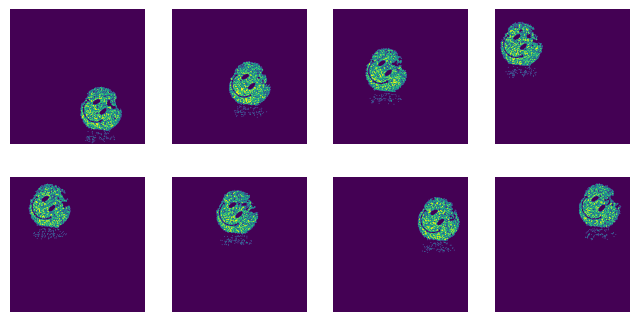

In [79]:
img_dir="ball.jpg"
img_pil=Image.open(img_dir)
width, height = img_pil.size 
newsize = (int(width/2), int(height/2))
img_pil = img_pil.resize(newsize)

img= np.array(img_pil, dtype='float')/255.0
img = img[:,:,0:3]

nx,ny,nc = img.shape


shifts = 2.* np.array([[0,0],[28,15], [43,42], [72,72], [79,57], [72,29], [64,-16], [79,-15]])
frames = shifts.shape[0]
center = np.array([nx/2,ny/2])
win_size = np.array([300,300])
vid = np.zeros((win_size[0],win_size[1],nc,frames))
likelihood = np.zeros((win_size[0],win_size[1],frames))

fig = plt.figure(figsize=(8, 4))
columns = 4
rows = 2
for i in range(frames):
    c = center + shifts[i,:]
    vid[:,:,:,i] = img[int(c[0]-win_size[0]/2):int(c[0]+win_size[0]/2),int(c[1]-win_size[1]/2):int(c[1]+win_size[1]/2),:]

    if (1+i)%1==0:
        vid[:,:,:,i] = (vid[:,:,:,i]+0.1*np.random.randn(win_size[0],win_size[1],3)).clip(0,1)
        
    likelihood[:,:,i] = (vid[:,:,0,i]-gaussian_filter(np.mean(vid[:,:,1:3,i], axis=2),sigma=2))>0.7
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(likelihood[:,:,i])
    plt.axis('off')

#likelihood = torch.from_numpy(likelihood>0.35).float()
plt.show()



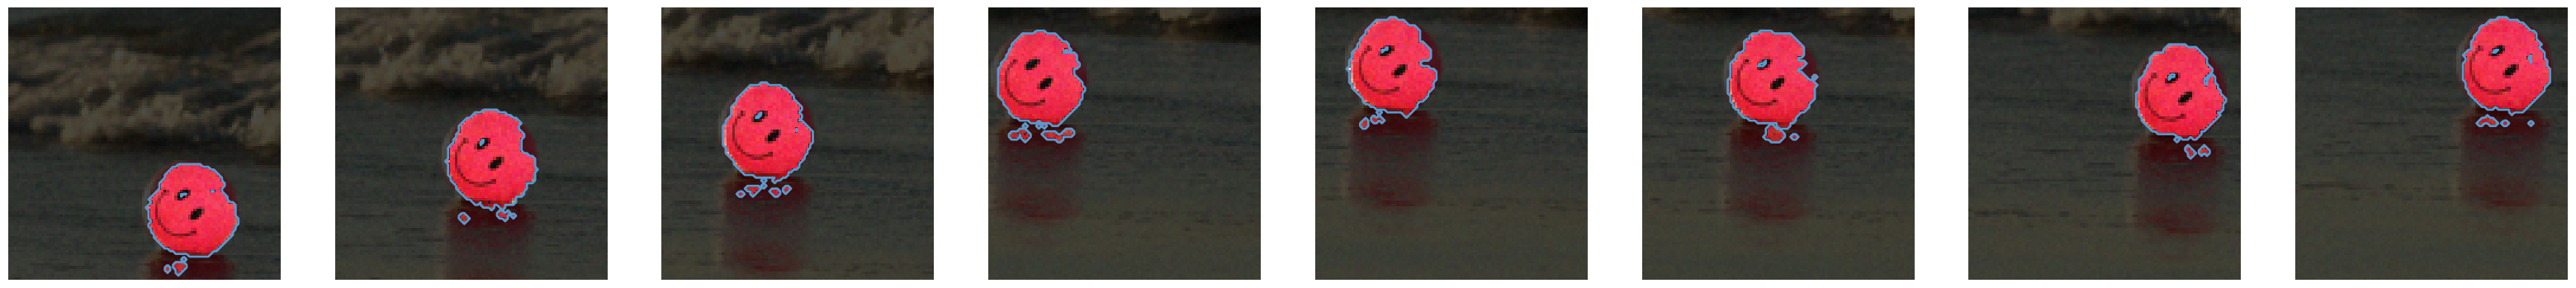

In [80]:

import cv2 as cv

def resize_pillow(arr, target_px, target_py):
    return np.array(Image.fromarray(arr).resize((target_px, target_py)))

clean_imgs = []
for i in range(8):
    clean_imgs.append(resize_pillow((vid[:,:,:,i] * 255).astype(np.uint8), 100, 100))
clean_imgs = np.stack(clean_imgs, axis=0)

loaded_masks = []
for i in range(8):
    path = f"original/mask_{i}_naive.png"
    msk = load_mask_single_channel(path)
    msk = ((msk > 127).astype(float) * 255).astype(np.uint8)
    # Save
    cv.imwrite(path, msk)
    loaded_masks.append(msk)
loaded_masks = np.stack(loaded_masks, axis=0)

fig, axes = get_mpl_figure(1, 8, ratio_or_img=1, tight=False)
for i in range(8):
    plot_mask(clean_imgs[i], loaded_masks[i], ax=axes[i], tight=False)
display(fig)
plt.close("all")



In [28]:
vid[..., i].shape

(300, 300, 3)

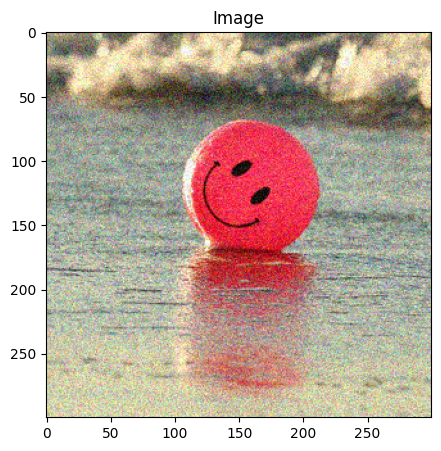

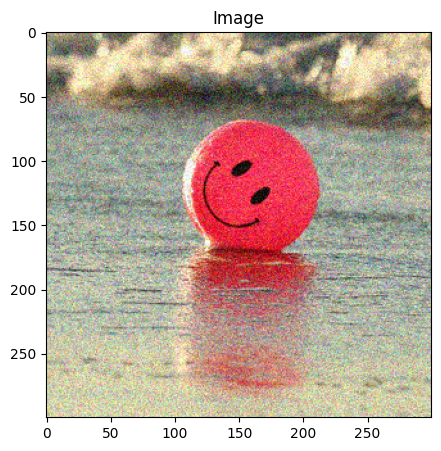

In [6]:
plot_as_image(vid[..., -3])

In [3]:

class myNet(nn.Module):
    def __init__(self,n_hidden):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.offset = torch.nn.Parameter(torch.zeros(1,3))
        self.offset.requires_grad = False
        self.W0 = nn.Linear(3, n_hidden)
        self.W1 = nn.Linear(n_hidden, n_hidden)
        self.W2 = nn.Linear(n_hidden, 1)
        
        self.W1_r = nn.Linear(1, n_hidden)
        self.W2_r = nn.Linear(n_hidden,1)
        
        
    def forward(self, x):
        # define forward pass
        x = x+self.offset
        r = torch.sqrt(torch.sum(x**2,dim=1, keepdim=True))
        x = x/(0.01+r)
        
        x_old = F.relu(self.W0(x))
        r_aug = F.relu(self.W1(x_old)+self.W1_r(r))
        x = (self.W2(x_old) + self.W2_r(r_aug))
        return x

In [6]:
def extractInformationFromLikelihood(likelihood, mask):
    indices = torch.nonzero(mask)
    N_fore = indices.shape[0]
    print(N_fore)
    pixel_info = torch.zeros((N_fore,3)) # store x,y values of all pixels the user marked as foreground

    labels = torch.zeros(N_fore)
    pixel_info[:,0] = indices[:,0] / (nx-1) -0.5
    pixel_info[:,1] = indices[:,1] / (ny-1) -0.5
    pixel_info[:,2] = (indices[:,2] / (frames-1) - 0.5)*0.1
    labels = 1-likelihood[mask]
    return pixel_info, labels

pix_back,labels_back = extractInformationFromLikelihood(likelihood,  likelihood<0.5)
pix_fore,labels_fore = extractInformationFromLikelihood(likelihood, likelihood>0.5)

691915
28085


In [5]:
net = myNet(200)

num_epochs = 5000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)  
number = 500*frames

# Train the model
for epoch in range(num_epochs):
    perm = torch.randperm(pix_back.size(0))
    idx = perm[:number]
    random_pix_back = pix_back[idx,:]
    pix_back_labels = labels_back[idx]
    
    perm = torch.randperm(pix_fore.size(0))
    idx = perm[:number]
    random_pix_fore = pix_fore[idx,:]
    pix_fore_labels = labels_fore[idx]
    
    
    outputs_back = torch.sigmoid(net(random_pix_back)).squeeze()
    outputs_fore = torch.sigmoid(net(random_pix_fore)).squeeze()
    
    loss = 2*criterion(outputs_back, pix_back_labels) + 1*criterion(outputs_fore, pix_fore_labels)
    
    #outputs = torch.sigmoid(net(random_pix)).squeeze()
    
    #loss = criterion(outputs, pix_labels) 
    if epoch ==1000:
        net.offset.requires_grad = True
    #    loss += 0.1*torch.sum(torch.sigmoid(net(net.offset.data)))
    
    #print(torch.sigmoid(net(net.offset.data)))
        
    # Backprpagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        net.W2_r.weight.data = F.relu(net.W2_r.weight.data)

    if (epoch+1) % 400 == 0:
        print ('Epoch [{}/{}],  Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item()))

Epoch [400/5000],  Loss: 0.1956
Epoch [800/5000],  Loss: 0.1403
Epoch [1200/5000],  Loss: 0.1249
Epoch [1600/5000],  Loss: 0.1285
Epoch [2000/5000],  Loss: 0.1181
Epoch [2400/5000],  Loss: 0.1208
Epoch [2800/5000],  Loss: 0.1181
Epoch [3200/5000],  Loss: 0.1229
Epoch [3600/5000],  Loss: 0.1117
Epoch [4000/5000],  Loss: 0.1080
Epoch [4400/5000],  Loss: 0.1058
Epoch [4800/5000],  Loss: 0.1247


In [9]:
vid.shape

(300, 300, 3, 8)

In [7]:
allPixels,temp = extractInformationFromLikelihood(likelihood,  likelihood>-0.5)

inferenceResult = net(allPixels) # torch tensor of size nx*ny
inferenceResult = inferenceResult.detach().numpy().reshape((win_size[0],win_size[1],frames))
fac = 4
cx = torch.zeros(frames*fac-fac+1)
cy = torch.zeros(frames*fac-fac+1)

fig = plt.figure(figsize=(12, 4))
columns = 8
rows = 1
for i in range(frames):
    c = center + shifts[i,:]
    
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(vid[:,:,:,i])
    plt.contour(likelihood[:,:,i], levels=[0.5], colors='purple')
    plt.plot((cy[:i+1]+0.5)*win_size[0],(cx[:i+1]+0.5)*win_size[1],'-')
    plt.plot((cy[i]+0.5)*win_size[0],(cx[i]+0.5)*win_size[1],'x')
    plt.axis('off')


#plt.savefig('result_naive.png',bbox_inches='tight')
plt.show()



720000


NameError: name 'net' is not defined

In [4]:
fac = 4
indices = torch.nonzero(torch.ones(win_size[0],win_size[1],frames*fac-fac+1))
N_fore = indices.shape[0]
pixel_info = torch.zeros((N_fore,3)) # store x,y values of all pixels the user marked as foreground

pixel_info[:,0] = indices[:,0] / (nx-1) -0.5
pixel_info[:,1] = indices[:,1] / (ny-1) -0.5
pixel_info[:,2] = (indices[:,2] / (fac*frames-fac+1-1) - 0.5)*0.1

inferenceResult = net(pixel_info) # torch tensor of size nx*ny
inferenceResult = inferenceResult.detach().numpy().reshape((win_size[0],win_size[1],fac*frames-fac+1))
grid_x, grid_y = torch.meshgrid(torch.linspace(-0.5,0.5,win_size[0]), torch.linspace(-0.5,0.5,win_size[1]), indexing='ij')

fig = plt.figure(figsize=(12, 8))
columns = 7
rows = 5
cx = torch.zeros(frames*fac-fac+1)
cy = torch.zeros(frames*fac-fac+1)
for i in range(frames*fac-fac+1):
      
    fig.add_subplot(rows, columns, i+1)
    if i%fac==0:
        plt.imshow(vid[:,:,:,int(i/fac)])
    else:
        temp = np.ones((win_size[0],win_size[1],3))
        temp[0:2,:,:]=0
        temp[:,0:2,:]=0
        temp[:,-2:,:]=0
        temp[-2:,:,:]=0
        plt.imshow(inferenceResult[:,:,i]<0, cmap='gray')
    #plt.contour(inferenceResult[:,:,i], levels=[0.0], colors='purple')
    plt.contour(inferenceResult[:,:,i], levels=[0.0], colors='purple')
    cx[i] = torch.sum(grid_x*(inferenceResult[:,:,i]<0))/((inferenceResult[:,:,i]<0).sum())
    cy[i] = torch.sum(grid_y*(inferenceResult[:,:,i]<0))/((inferenceResult[:,:,i]<0).sum())
    #cx[i] = torch.sum(grid_x*(likelihood[:,:,i]>0.5))/((likelihood[:,:,i]>0.5).sum())
    #cy[i] = torch.sum(grid_y*(likelihood[:,:,i]>0.5))/((likelihood[:,:,i]>0.5).sum())
    
    plt.plot((cy[:i+1]+0.5)*win_size[0],(cx[:i+1]+0.5)*win_size[1],'-')
    plt.plot((cy[i]+0.5)*win_size[0],(cx[i]+0.5)*win_size[1],'x')
    #print(cx,cy)
    
    plt.axis('off')

#plt.savefig('result_naive2.png',bbox_inches='tight')
plt.show()



NameError: name 'net' is not defined

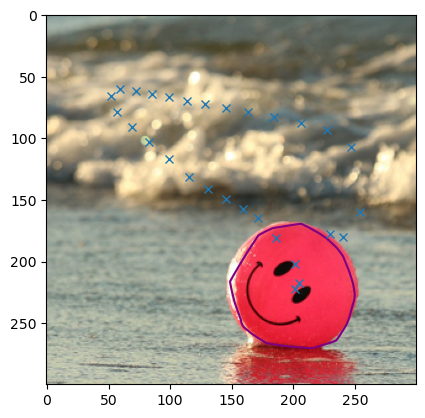

In [158]:
plt.imshow(vid[:,:,:,0])
plt.contour(inferenceResult[:,:,0], levels=[0.0], colors='purple')
plt.plot((cy+0.5)*win_size[0],(cx+0.5)*win_size[1],'x')
#plt.colorbar()

In [92]:
print(frames)
print((np.array(range(8*3-2)) / (3*frames-2-1) - 0.5)*0.1)
print((np.array(range(8)) / (frames-1) - 0.5)*0.1)

8
[-0.05       -0.0452381  -0.04047619 -0.03571429 -0.03095238 -0.02619048
 -0.02142857 -0.01666667 -0.01190476 -0.00714286 -0.00238095  0.00238095
  0.00714286  0.01190476  0.01666667  0.02142857  0.02619048  0.03095238
  0.03571429  0.04047619  0.0452381   0.05      ]
[-0.05       -0.03571429 -0.02142857 -0.00714286  0.00714286  0.02142857
  0.03571429  0.05      ]


In [81]:
import cv2 as cv

def resize_pillow(arr, target_px, target_py):
    return np.array(Image.fromarray(arr).resize((target_px, target_py)))

for i in range(vid.shape[-1]):
    path = f"img_{i}.png"
    im = cv.cvtColor(resize_pillow((vid[:,:,:,i] * 255).astype(np.uint8), 100, 100), cv.COLOR_RGB2BGR)
    cv.imwrite(path, im)    

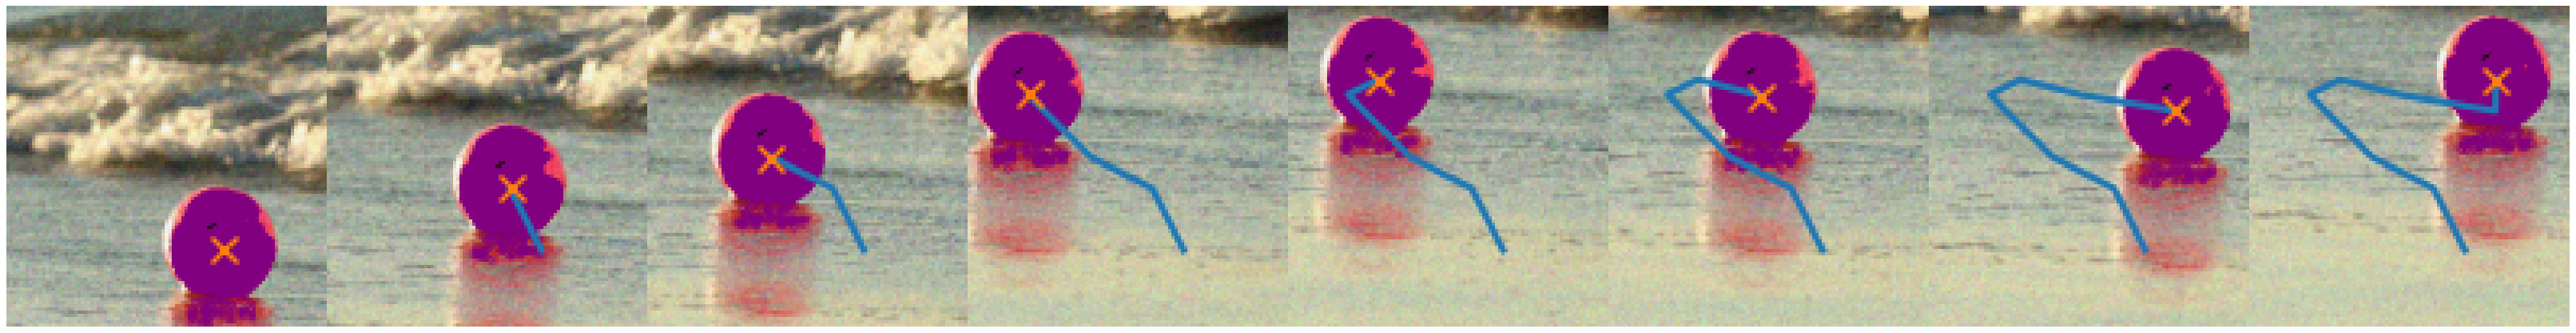

(99, 99, 3)
(99, 99, 3)
(99, 99, 3)
(99, 99, 3)
(99, 99, 3)
(99, 99, 3)
(99, 99, 3)
(99, 99, 3)


In [32]:
import cv2 as cv
def load_image(path):
    im = cv.imread(path)
    if im is None:
        raise FileNotFoundError(f"File not found: {path}")
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    return im

naive_img = load_image("original/temporal_naive.png")

imgs = []
start_x = 0
image_width = 99
image_height = 99
offset_x = 10
offset_y = 9

for i in range(8):
    coffset_x = offset_x if (i not in [2, 6]) else offset_x -1
    start_x += coffset_x
    imgs.append(naive_img[offset_y:offset_y+image_height, start_x:start_x+image_width])
    start_x += (image_width + offset_x)

fig, axes = get_mpl_figure(1, 8, ratio_or_img=1, tight=True)
for i in range(8):
    plot_as_image(imgs[i], axes=axes[i], tight=True)
display(fig)
plt.close("all")

imgs = np.stack(imgs, axis=0)

for i in range(8):
    print(imgs[i].shape)

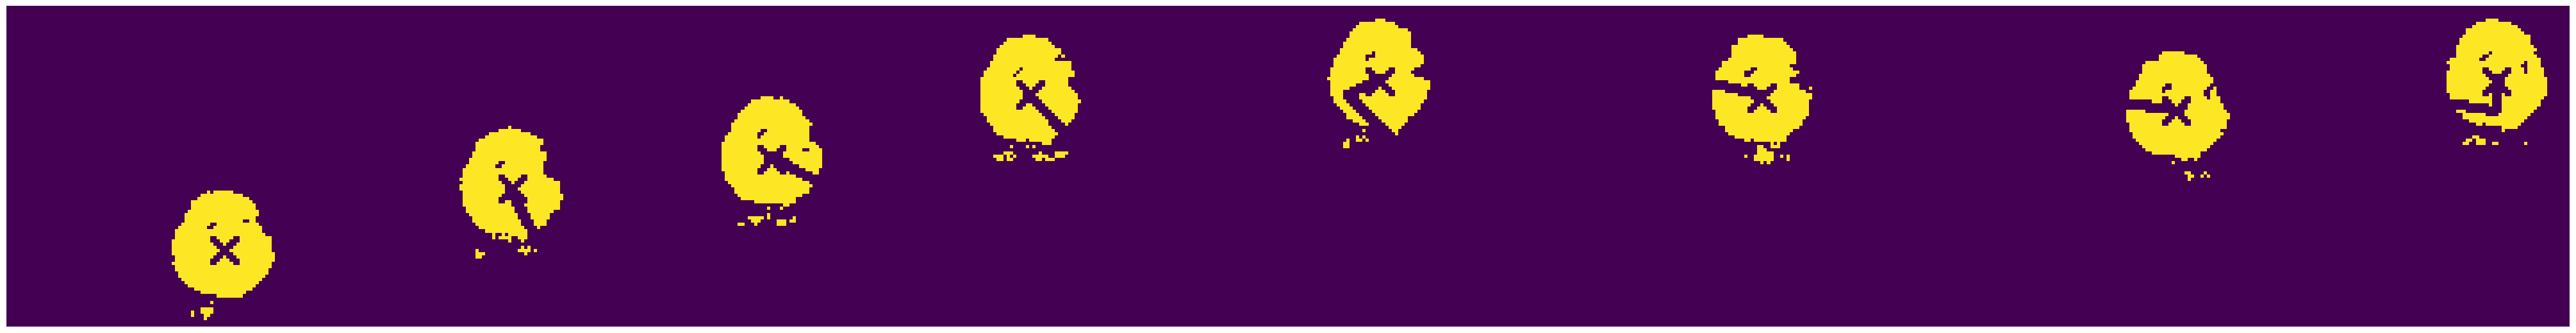

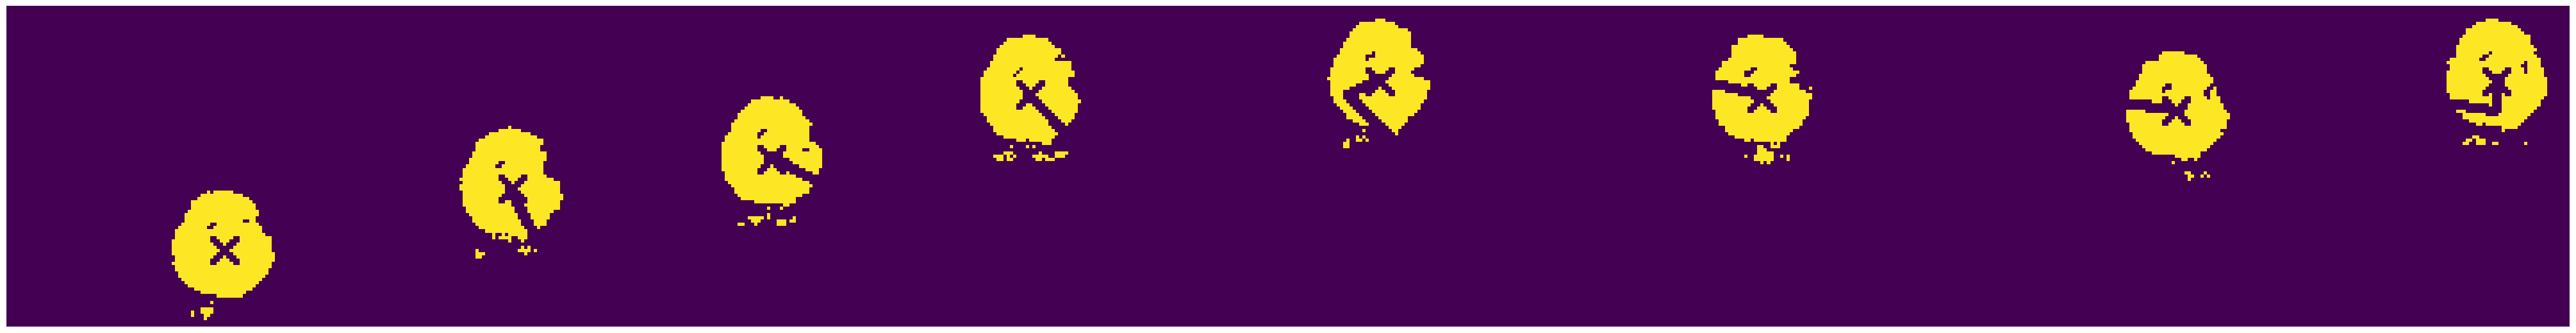

In [33]:
# naive_mask_cond = (imgs[..., 0] > (120 / 255)) & (imgs[..., 2] > (120 / 255)) & (imgs[..., 1] < (10 / 255))
# fig, axes = get_mpl_figure(1, 8, ratio_or_img=1, tight=True)
# for i in range(8):
#     plot_as_image(naive_mask_cond[i], axes=axes[i], tight=True)
# display(fig)

# def write_mask(mask, path):
#     mask = (mask * 255).astype(np.uint8)
#     cv.imwrite(path, mask)

# for i in range(8):
#     write_mask(naive_mask_cond[i], f"mask_{i}_naive.png")
    

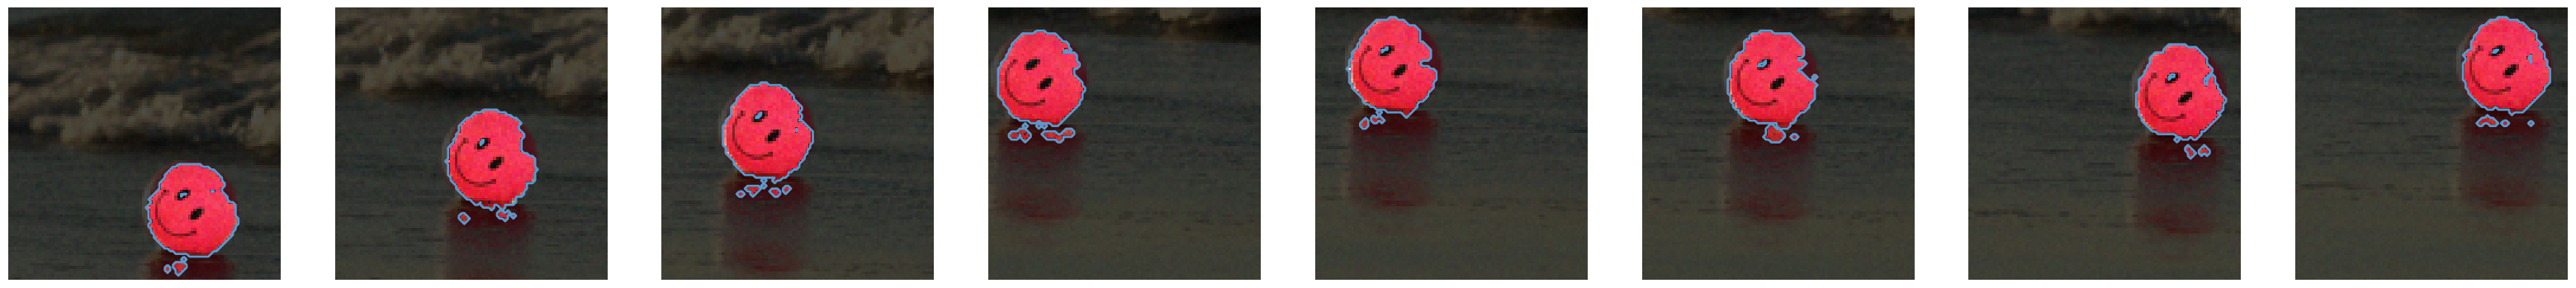

In [33]:
loaded_masks = []

for i in range(8):
    path = f"original/mask_{i}_naive.png"
    msk = load_mask_single_channel(path)
    loaded_masks.append(msk)
loaded_masks = np.stack(loaded_masks, axis=0)

clean_imgs = []
for i in range(8):
    clean_imgs.append(load_image(f"img_{i}.png"))
clean_imgs = np.stack(clean_imgs, axis=0)

fig, axes = get_mpl_figure(1, 8, ratio_or_img=1, tight=False)
for i in range(8):
    plot_mask(clean_imgs[i], loaded_masks[i], ax=axes[i], tight=False)
display(fig)
plt.close("all")

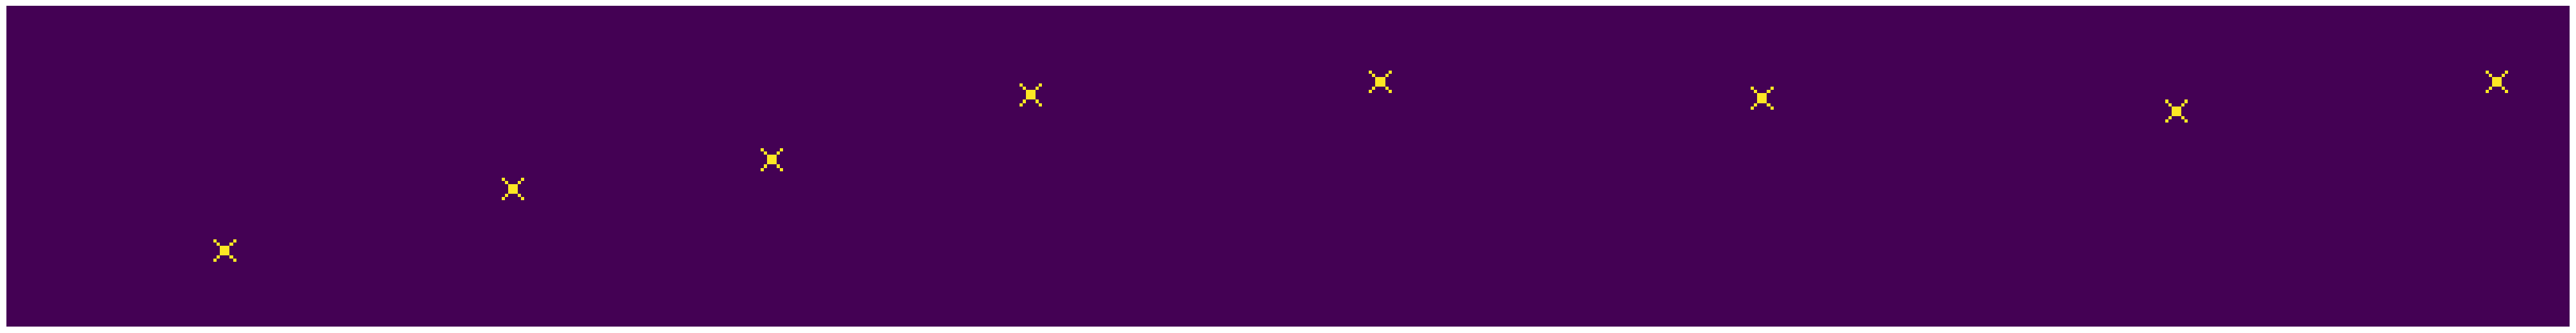

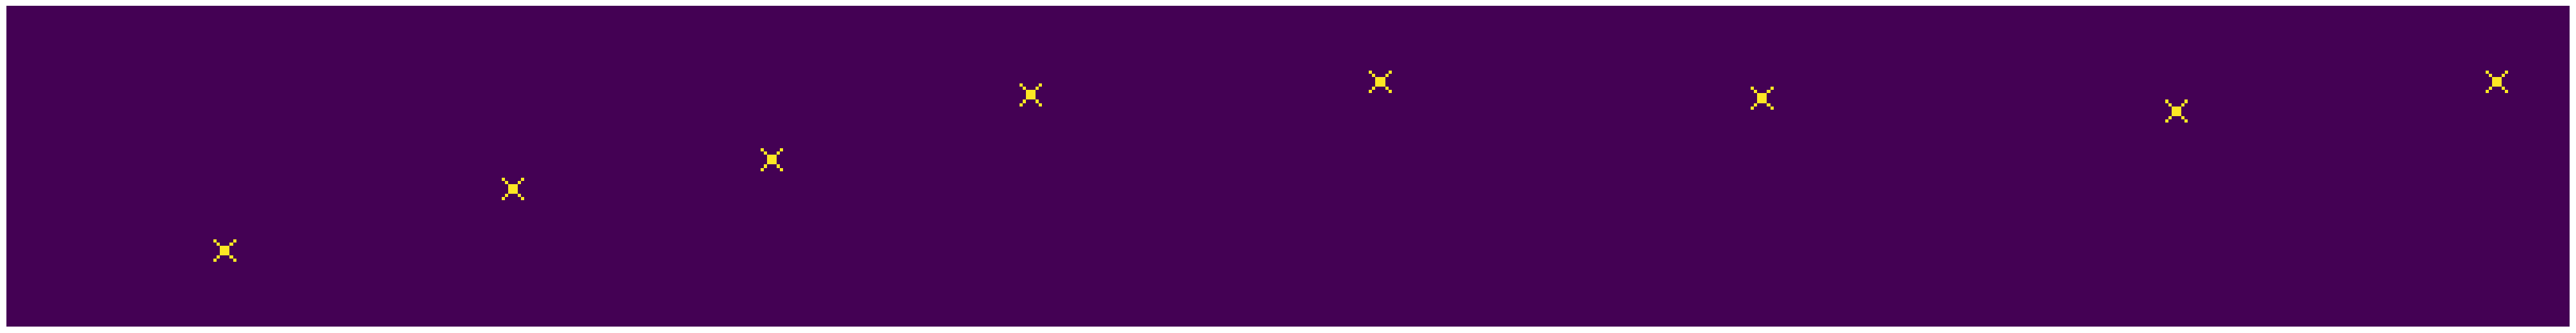

In [34]:
imgsn = imgs / 255.
center_cond = (((1.) >= imgsn[..., 0]) & (imgsn[..., 0] > (245 / 255))) & \
                (((140 / 255) > imgsn[..., 1]) &(imgsn[..., 1] > (120 / 255))) & \
                (((20 / 255) > imgsn[..., 2]) & (imgsn[..., 2] > (10 / 255)))

center = [ np.average(indices) for indices in np.where(center_cond.astype(float) >= 1.) ]

centers = []
for i in range(8):
    indices = np.where(center_cond[i].astype(float) >= 1.)
    centers.append([np.average(indices[0]), np.average(indices[1])])

centers = np.stack(centers, axis=0).astype(int)
centers_rel = centers / np.array(imgs.shape[-3:3])

fig, axes = get_mpl_figure(1, 8, ratio_or_img=1, tight=True)
for i in range(8):
    plot_as_image(center_cond[i], axes=axes[i], tight=True)
display(fig)

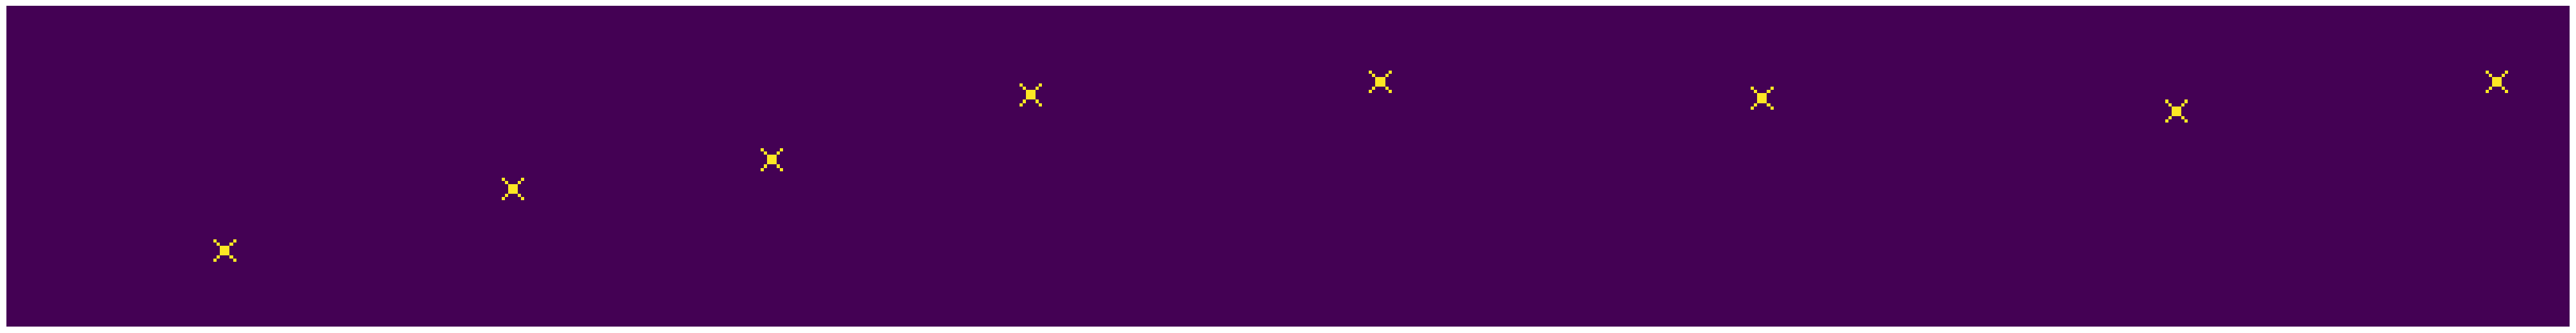

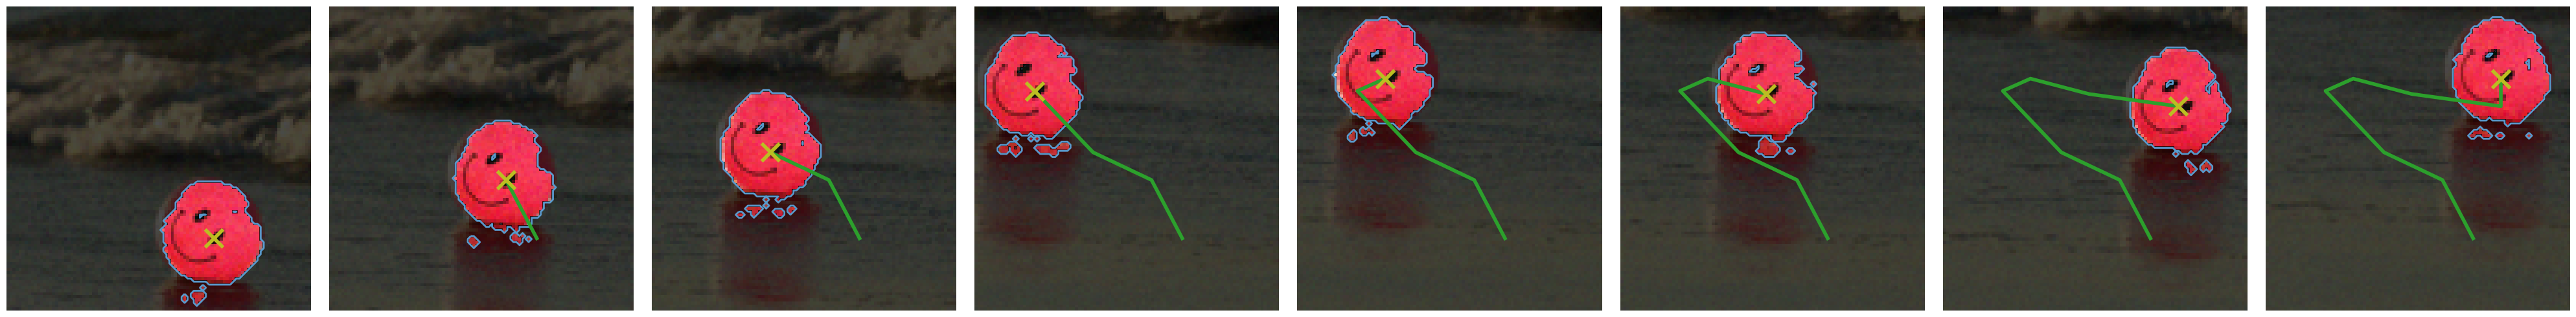

In [35]:

@saveable()
def plot_trace(imgs, masks, centers, size:float = 3):
    fig, axes = get_mpl_figure(1, 8, ratio_or_img=1, size=size, tight=False)
    mcolor = plt.get_cmap("tab10")(8)
    lcolor = plt.get_cmap("tab10")(2)

    l_shifts = []
    cen = (centers * imgs[0].shape[:-1]) # Y, X
    for i in range(imgs.shape[0]):
        ax = axes[i]
        plot_mask(imgs[i], masks[i], ax=ax, tight=False)
        ax.scatter(*cen[i, ::-1], color=mcolor, marker="x", s=400, linewidths=4, zorder=10)
        if i > 0: 
            loc_centers = cen[:i + 1]
            x, y = loc_centers[..., 1], loc_centers[..., 0]
            ax.plot(x, y, color=lcolor, linewidth=4)
    return fig
plt.close("all")

plot_trace(clean_imgs, loaded_masks, centers_rel, save=True, size=5, open=True, tight_layout=True, override=True, path="new/temporal_connected_naive", ext=["png", "pdf"])
fig

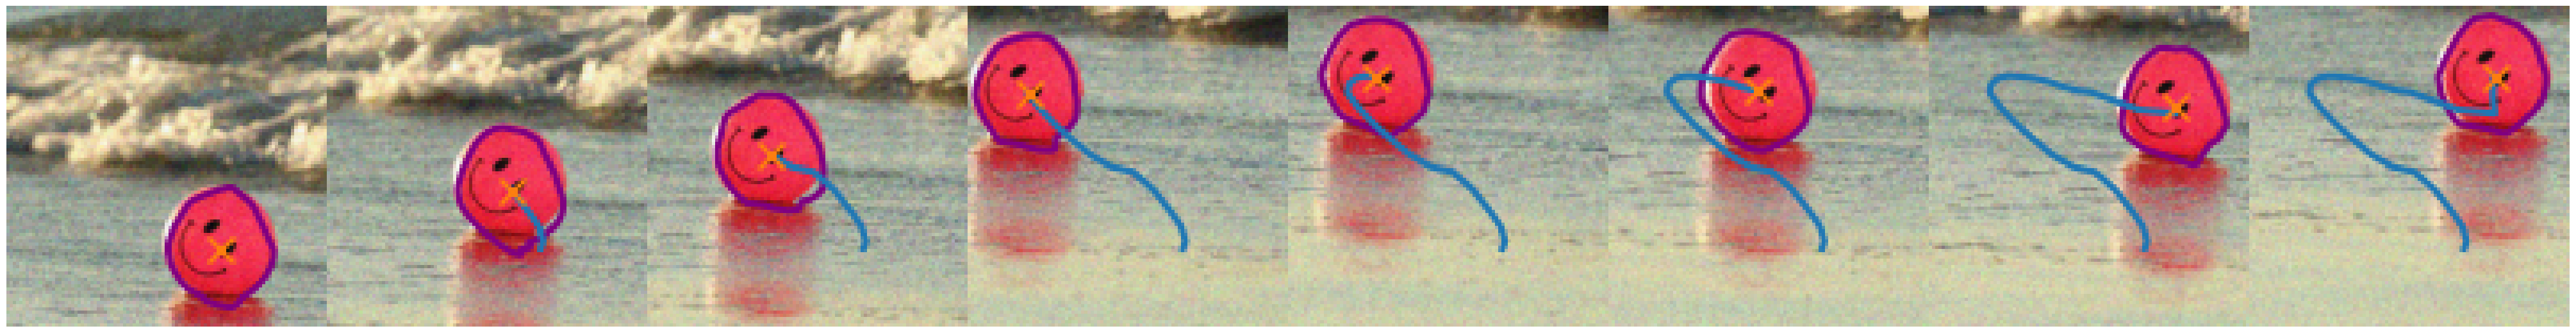

(99, 99, 3)
(99, 99, 3)
(99, 99, 3)
(99, 99, 3)
(99, 99, 3)
(99, 99, 3)
(99, 99, 3)
(99, 99, 3)


In [2]:
import cv2 as cv
def load_image(path):
    im = cv.imread(path)
    if im is None:
        raise FileNotFoundError(f"File not found: {path}")
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    return im

naive_img = load_image("original/temporal.png")

imgs = []
start_x = 0
image_width = 99
image_height = 99
offset_x = 10
offset_y = 9

for i in range(8):
    coffset_x = offset_x if (i not in [2, 6]) else offset_x -1
    start_x += coffset_x
    imgs.append(naive_img[offset_y:offset_y+image_height, start_x:start_x+image_width])
    start_x += (image_width + offset_x)

fig, axes = get_mpl_figure(1, 8, ratio_or_img=1, tight=True)
for i in range(8):
    plot_as_image(imgs[i], axes=axes[i], tight=True)
display(fig)
plt.close("all")

imgs = np.stack(imgs, axis=0)

for i in range(8):
    print(imgs[i].shape)

In [19]:
for i in range(8):
    im = imgs[i]
    img = resize_pillow(im, 100, 100)
    cv.imwrite(f"test/img_{i}.png", cv.cvtColor(img, cv.COLOR_RGB2BGR))

In [152]:
pmask = []
for i in range(8):
    path = f"test/mask_{i}.png"
    msk = load_mask_single_channel(path)
    pmask.append(msk)
pmask = np.stack(loaded_masks, axis=0)

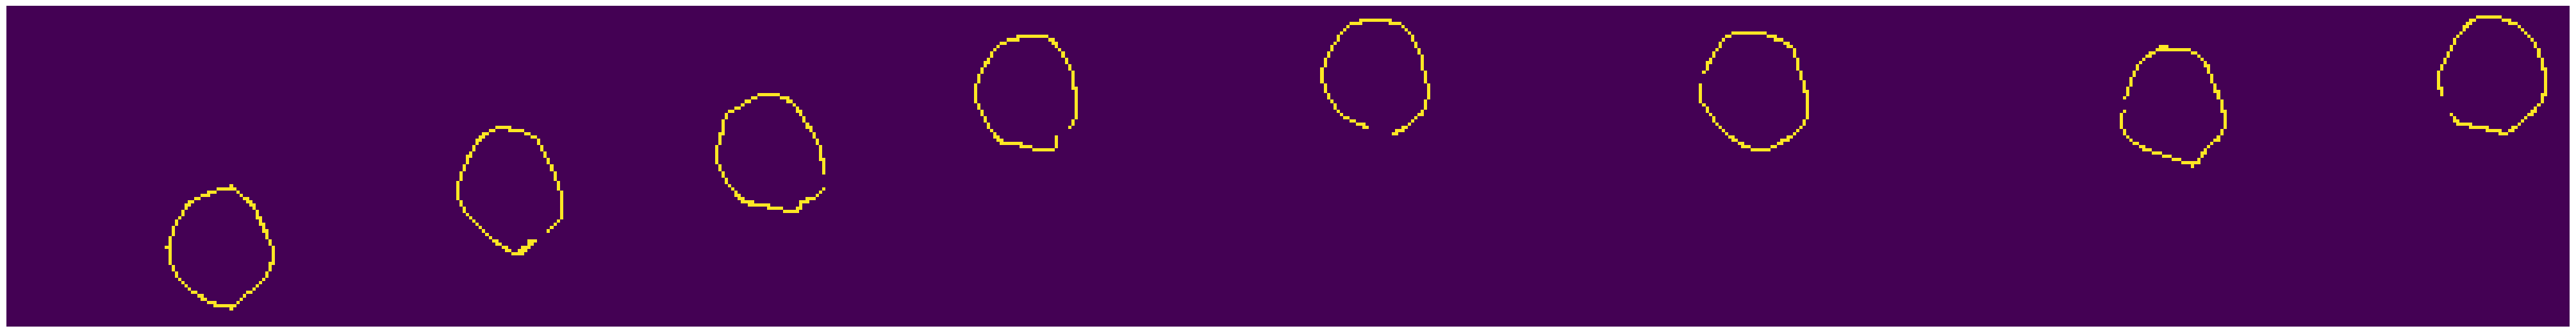

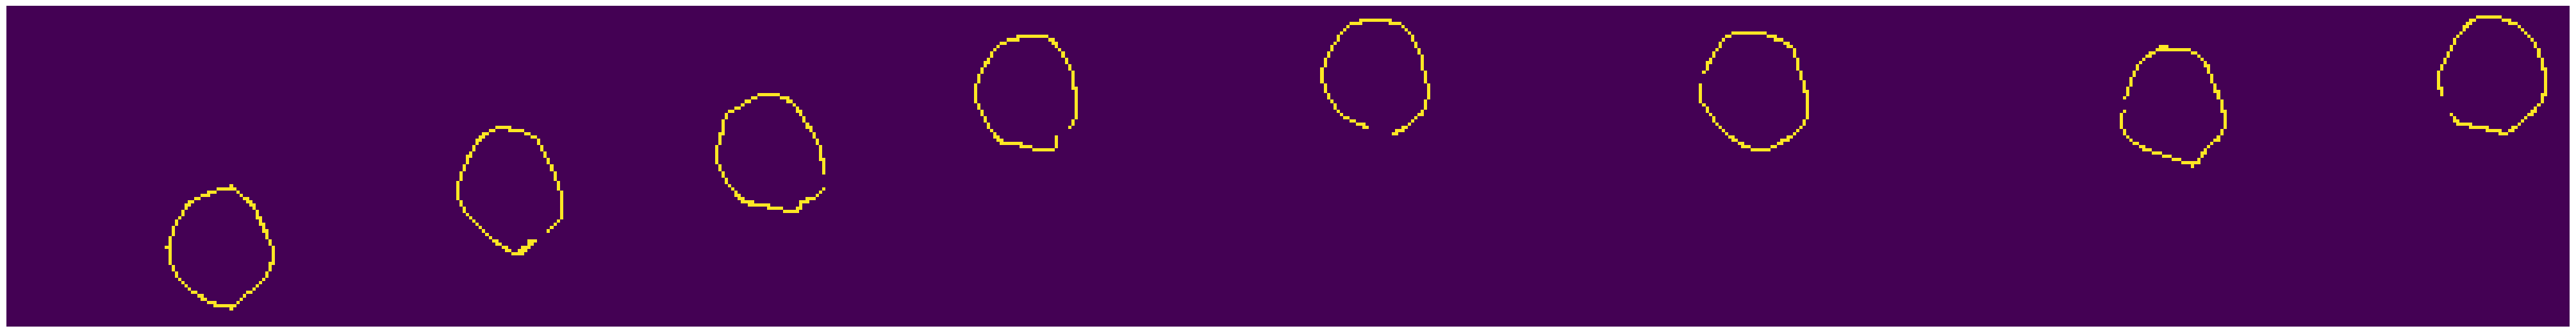

In [148]:
mask_cond = (imgs[..., 0] > (120 / 255)) & (imgs[..., 2] > (120 / 255)) & (imgs[..., 1] < (10 / 255))
fig, axes = get_mpl_figure(1, 8, ratio_or_img=1, tight=True)
for i in range(8):
    plot_as_image(mask_cond[i], axes=axes[i], tight=True)
display(fig)

def write_mask(mask, path):
    mask = (mask * 255).astype(np.uint8)
    cv.imwrite(path, mask)

# thinnedx = []
# for i in range(8):
#     thinned = cv.ximgproc.thinning((mask_cond[i].astype(float) * 255).astype(np.uint8), thinningType = cv2.ximgproc.THINNING_ZHANGSUEN)
#     thinnedx.append(thinned)

for i in range(8):
    write_mask(mask_cond[i], f"test/mask_{i}.png")
    #write_mask(thinnedx[i], f"test/mask_{i}_thin.png")
    

In [ ]:
pmask = []
for i in range(8):
    path = f"test/path_mask_{i}.png"
    msk = load_mask_single_channel(path)
    pmask.append(msk)
pmask = np.stack(loaded_masks, axis=0)

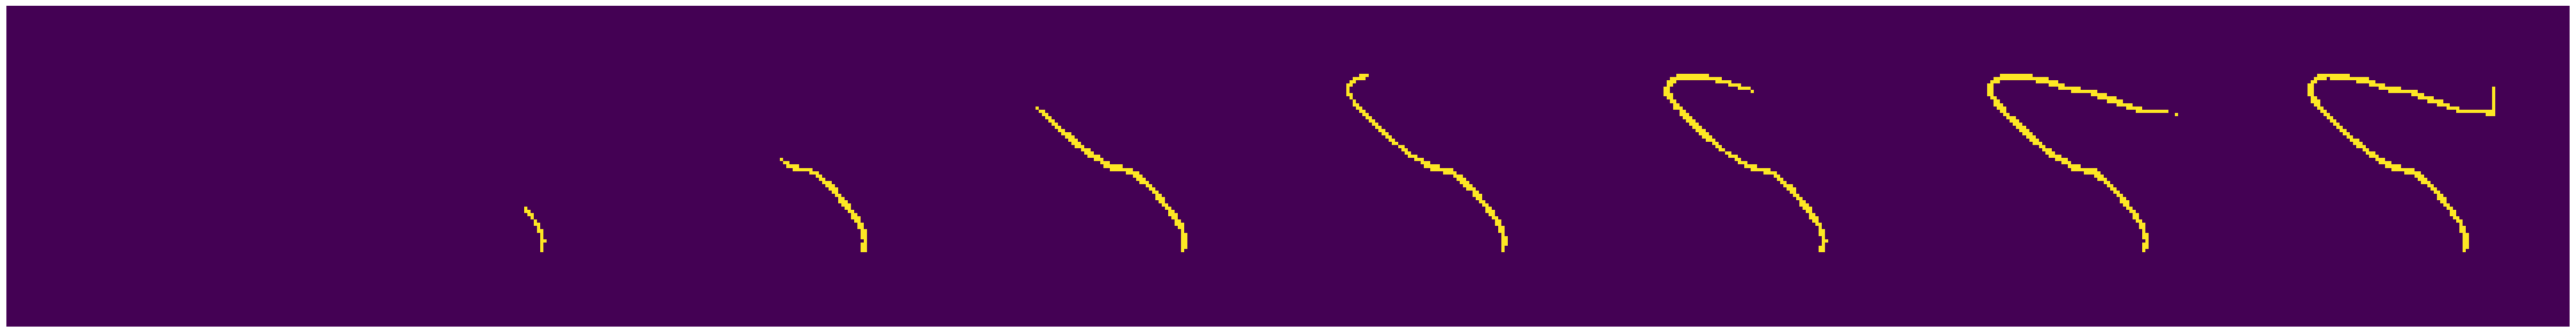

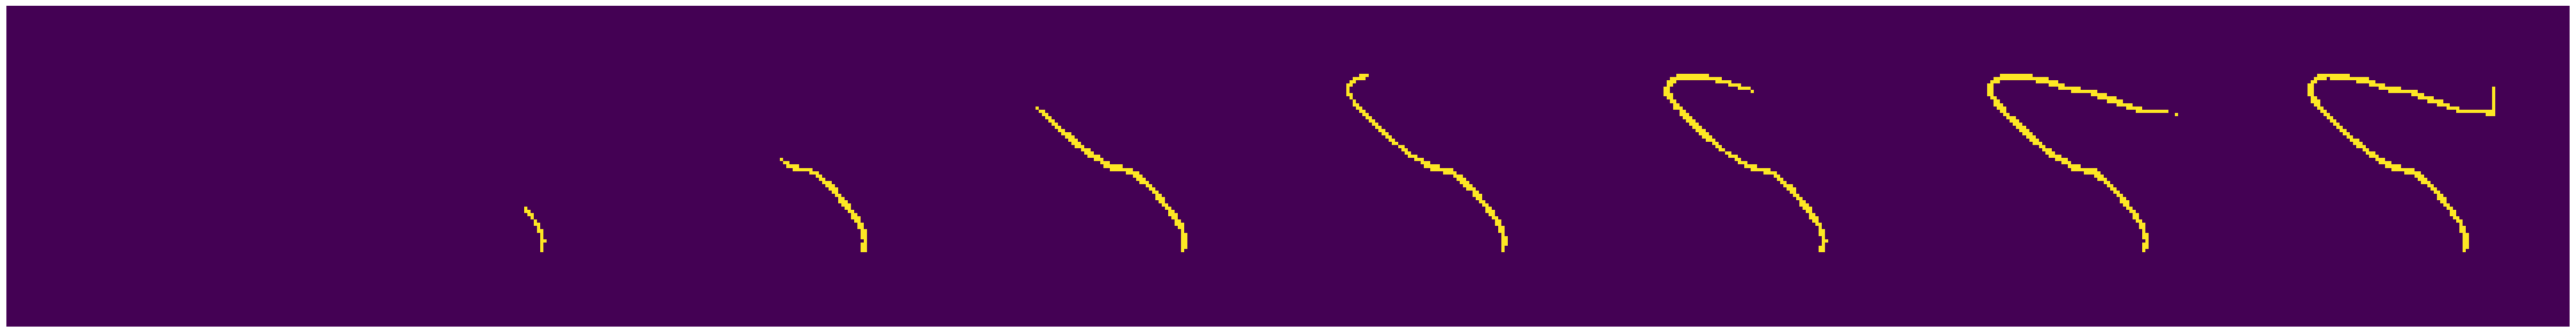

In [176]:
imgsn = imgs / 255.
mask_path_cond = (imgsn[..., 0] >= (20 / 255)) & (imgsn[..., 0] < (80 / 255)) & \
            (imgsn[..., 1] >= (100 / 255)) & (imgsn[..., 1] < (140 / 255)) &\
            (imgsn[..., 2] >= (170 / 255)) & (imgsn[..., 2] < (190 / 255)) 
            
fig, axes = get_mpl_figure(1, 8, ratio_or_img=1, tight=True)
for i in range(8):
    plot_as_image(mask_path_cond[i], axes=axes[i], tight=True)
display(fig)

def write_mask(mask, path):
    mask = (mask * 255).astype(np.uint8)
    cv.imwrite(path, mask)

thinnedx = []
for i in range(8):
    thinned = cv.ximgproc.thinning((mask_path_cond[i].astype(float) * 255).astype(np.uint8), thinningType = cv2.ximgproc.THINNING_ZHANGSUEN)
    thinnedx.append(thinned)

for i in range(8):
    write_mask(mask_path_cond[i], f"test/path_mask_{i}.png")
    #write_mask(thinnedx[i], f"test/mask_{i}_thin.png")
    

In [223]:
path_mask = []
for i in range(8):
    path = f"test/path_mask_{i}.png"
    msk = load_mask_single_channel(path)
    #msk = resize_pillow(msk, 100, 100)
    #msk = ((msk > 127).astype(float) * 255).astype(np.uint8)
    #cv.imwrite(path, msk)
    path_mask.append(msk)
path_mask = np.stack(loaded_masks, axis=0)

FileNotFoundError: [Errno 2] No such file or directory: 'test/path_mask_0_thin.png'

In [185]:
def write_mask(mask, path):
    mask = (mask * 255).astype(np.uint8)
    cv.imwrite(path, mask)

thinnedx = []
for i in range(8):
    thinned = cv.ximgproc.thinning(path_mask[i], thinningType = cv2.ximgproc.THINNING_ZHANGSUEN)
    thinnedx.append(thinned)

for i in range(8):
    write_mask(thinnedx[i] / 255, f"test/mask_{i}_thin.png")
    

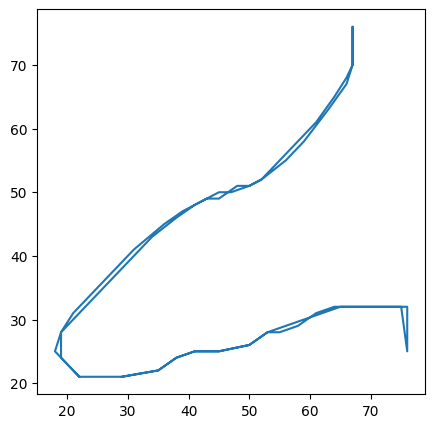

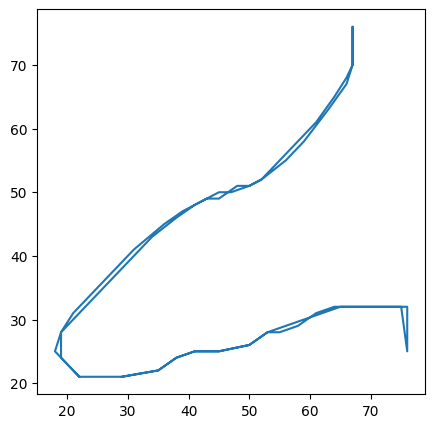

In [214]:
msk = thinnedx[-1]
contours, hierarchy = cv.findContours(msk, cv.RETR_TREE, cv.CHAIN_APPROX_TC89_L1)
contour = contours[0][:, 0, :]


fig, ax = get_mpl_figure(1,1)

line_start = np.array([67, 76])

buf = set()
contour = contours[0][:, 0, :]
si = np.argwhere(contour == line_start)

ax.plot(contour[:, 0], contour[:, 1])
fig

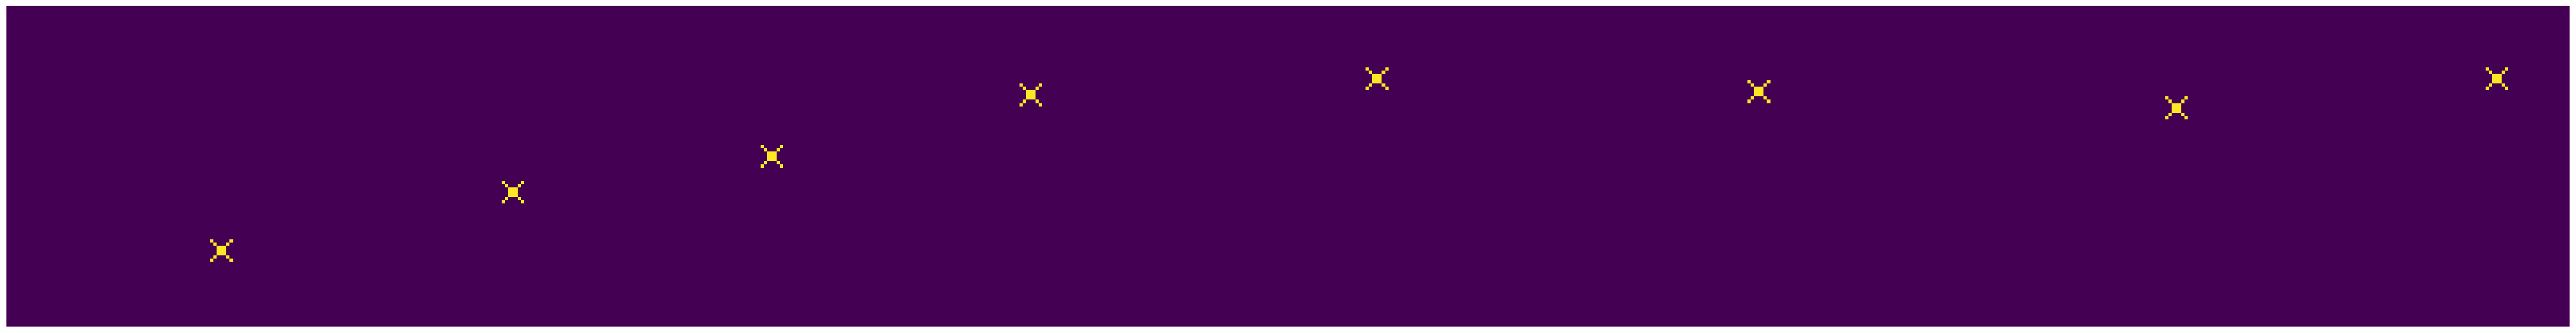

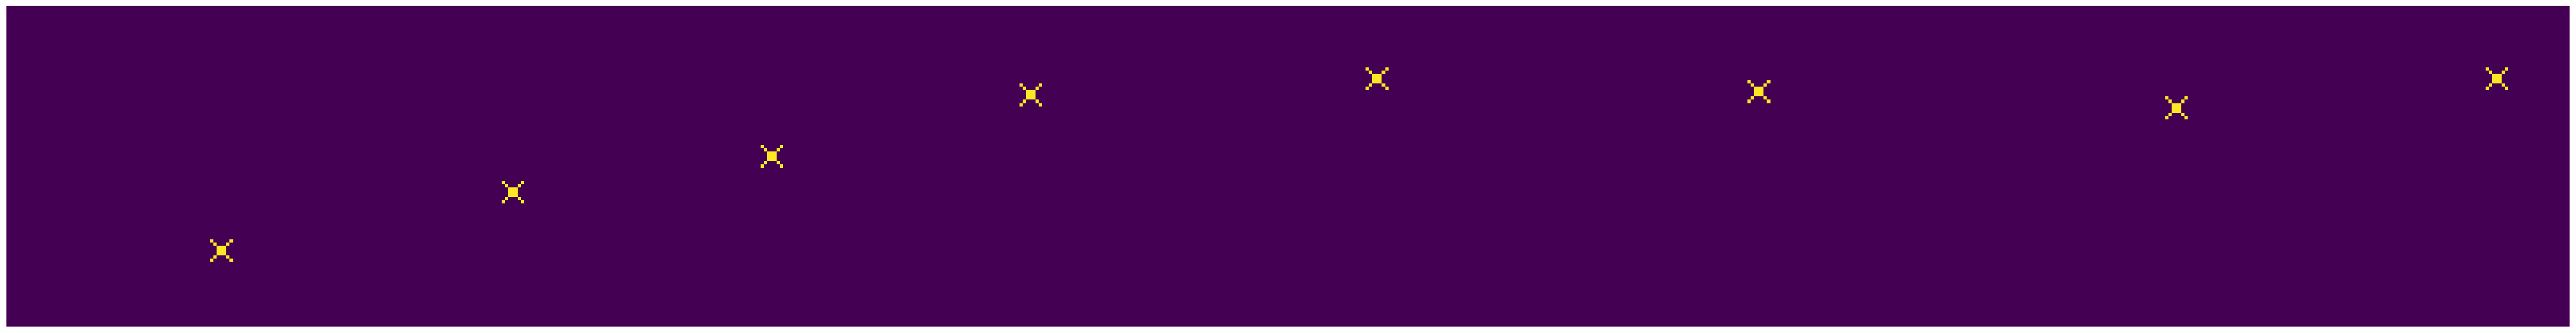

In [3]:
imgsn = imgs / 255.
center_cond = (((1.) >= imgsn[..., 0]) & (imgsn[..., 0] > (245 / 255))) & \
                (((140 / 255) > imgsn[..., 1]) &(imgsn[..., 1] > (120 / 255))) & \
                (((20 / 255) > imgsn[..., 2]) & (imgsn[..., 2] > (10 / 255)))

center = [ np.average(indices) for indices in np.where(center_cond.astype(float) >= 1.) ]

centers = []
for i in range(8):
    indices = np.where(center_cond[i].astype(float) >= 1.)
    centers.append([np.average(indices[0]), np.average(indices[1])])

centers = np.stack(centers, axis=0).astype(int)
centers_rel = centers / np.array(imgs.shape[-3:3])

fig, axes = get_mpl_figure(1, 8, ratio_or_img=1, tight=True)
for i in range(8):
    plot_as_image(center_cond[i], axes=axes[i], tight=True)
display(fig)

In [22]:
path_mask = []
for i in range(8):
    path = f"test/img_path_{i}.png"
    msk = load_mask_single_channel(path)
    msk = resize_pillow(msk, 100, 100)
    #msk = ((msk > 127).astype(float) * 255).astype(np.uint8)
    path_mask.append(msk)
path_mask = np.stack(path_mask, axis=0)

# contours = []

# for i in range(8):
#     msk = path_mask[i]
#     cts, hierarchy = cv.findContours(msk, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
#     if len(cts) == 0 or len(cts[0]) == 0:
#         contours.append([])
#         continue
#     contour = cts[0][:, 0, :]
#     contours.append(contour)


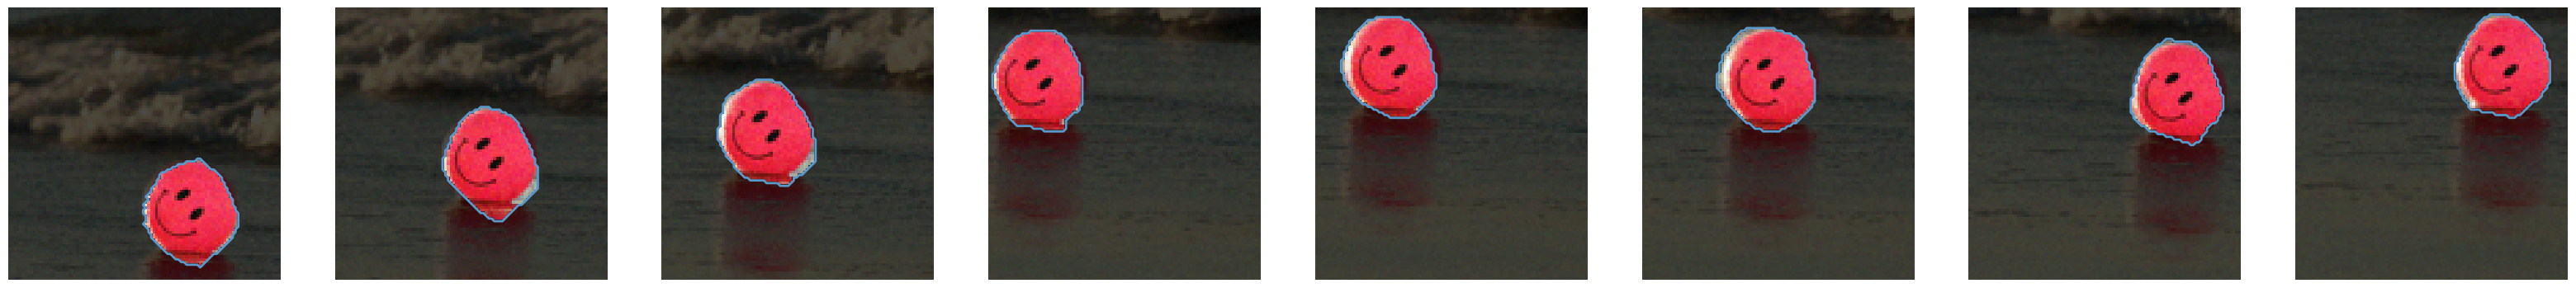

In [9]:
loaded_masks = []

for i in range(8):
    path = f"original/mask_{i}.png"
    msk = load_mask_single_channel(path)
    loaded_masks.append(msk)
loaded_masks = np.stack(loaded_masks, axis=0)

clean_imgs = []
for i in range(8):
    clean_imgs.append(load_image(f"img_{i}.png"))
clean_imgs = np.stack(clean_imgs, axis=0)

fig, axes = get_mpl_figure(1, 8, ratio_or_img=1, tight=False)
for i in range(8):
    plot_mask(clean_imgs[i], loaded_masks[i], ax=axes[i], tight=False)
display(fig)
plt.close("all")

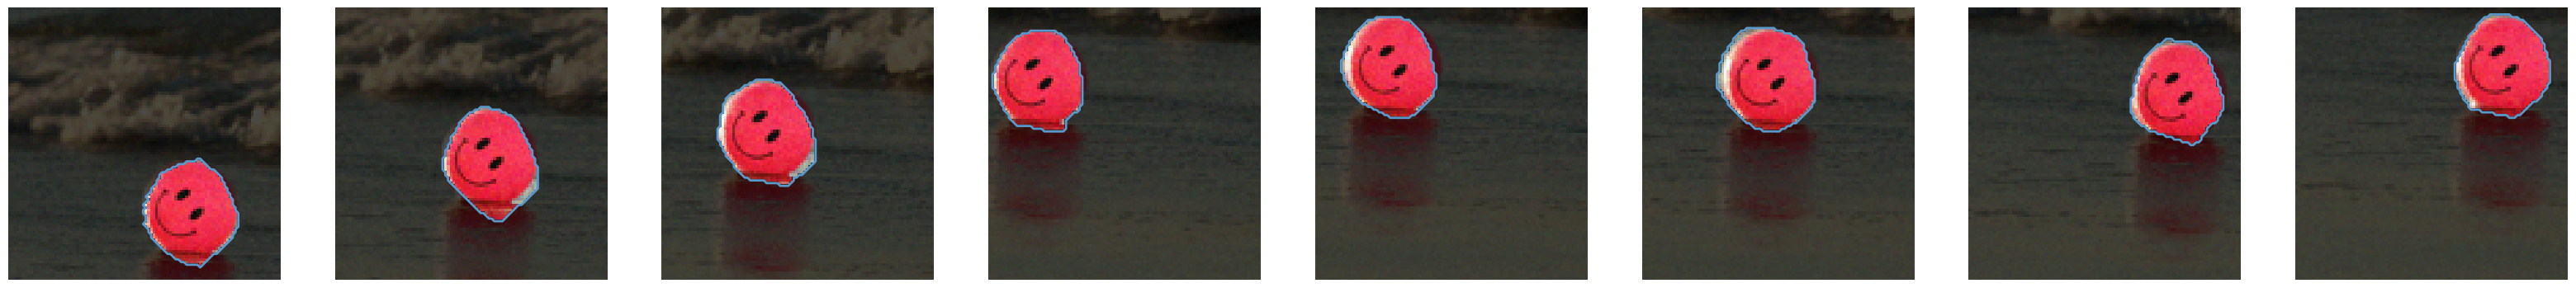

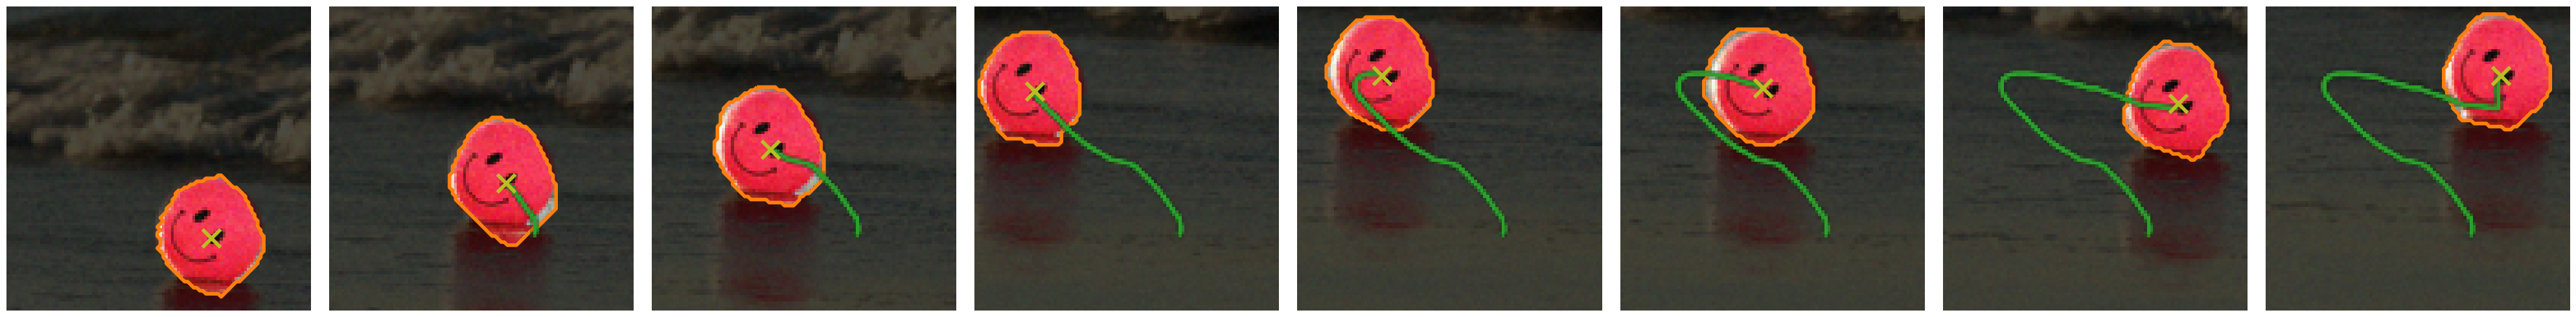

In [31]:

@saveable()
def plot_trace_interp(imgs, masks, centers, path_mask, size:float = 3):
    fig, axes = get_mpl_figure(1, 8, ratio_or_img=1, size=size, tight=False)
    mcolor = plt.get_cmap("tab10")(8)
    lcolor = plt.get_cmap("tab10")(2)
    color = plt.get_cmap("tab10")(1)
    l_shifts = []
    cen = (centers * imgs[0].shape[:-1]) # Y, X
    for i in range(imgs.shape[0]):
        ax = axes[i]
        plot_mask(imgs[i], masks[i], color=color, ax=ax, tight=False, contour_linewidths=4)
        ax.scatter(*cen[i, ::-1], color=mcolor, marker="x", s=400, linewidths=4, zorder=10)
        # if i > 0 and inter_paths is not None:
        #     ax.plot(inter_paths[i][..., 0], inter_paths[i][..., 1], linewidth=4, color=lcolor)
        if path_mask is not None:
            c = path_mask[i, ..., np.newaxis] / 255 * lcolor
            ax.imshow(c, zorder=8)
    return fig
plt.close("all")

plot_trace_interp(clean_imgs, loaded_masks, centers_rel, path_mask, save=True, size=5, open=True, tight_layout=True, override=True, path="new/temporal_connected", ext=["png"])
fig

In [239]:
contours

[]